In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
IMG_SIZE = (224, 224)   # requis par DenseNet
BATCH_SIZE = 32
EPOCHS = 20

# Chemins - À MODIFIER selon l'emplacement de vos dossiers dans Drive
TRAIN_DIR = '/content/drive/MyDrive/Training'  # Chemin vers le dossier Training
TEST_DIR = '/content/drive/MyDrive/Testing'    # Chemin vers le dossier Testing


In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)


In [8]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


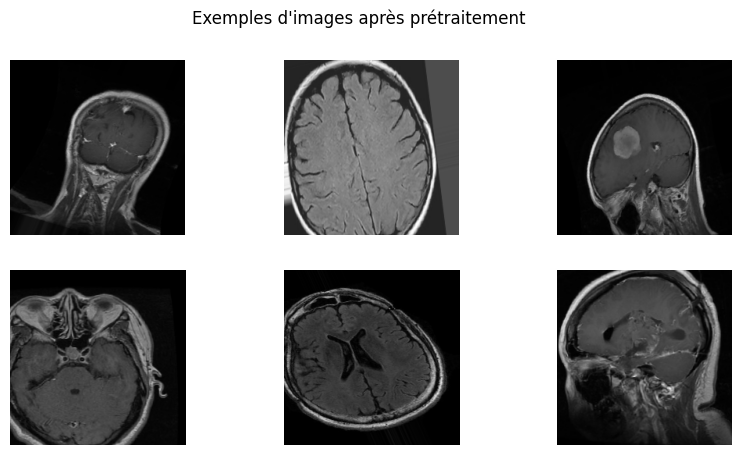

In [9]:
images, labels = next(train_generator)

plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i])
    plt.axis("off")
plt.suptitle("Exemples d'images après prétraitement")
plt.show()


In [10]:
base_model = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [11]:
for layer in base_model.layers:
    layer.trainable = False


In [12]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


In [13]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,300,932 (27.85 MB)

 Trainable params: 263,428 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [14]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)
]


In [15]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3881s 22s/step - accuracy: 0.4881 - loss: 1.2866 - val_accuracy: 0.7574 - val_loss: 0.6428 - learning_rate: 1.0000e-04
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 102s 568ms/step - accuracy: 0.7665 - loss: 0.6226 - val_accuracy: 0.8063 - val_loss: 0.5283 - learning_rate: 1.0000e-04
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 102s 568ms/step - accuracy: 0.8028 - loss: 0.5349 - val_accuracy: 0.7986 - val_loss: 0.5307 - learning_rate: 1.0000e-04
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 101s 563ms/step - accuracy: 0.8303 - loss: 0.4637 - val_accuracy: 0.8124 - val_loss: 0.4960 - learning_rate: 1.0000e-04
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 101s 565ms/step - accuracy: 0.8444 - loss: 0.4262 - val_accuracy: 0.8024 - val_loss: 0.4901 - learning_rate: 1.0000e-04
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 101s 563ms/step - accuracy: 0.8483 - loss: 0.4126 - val_accuracy: 0.8169 - val_loss: 0.4635 - learning_rate: 1.0000e-04
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 1

In [16]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy : {accuracy*100:.2f}%")


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.8408 - loss: 0.3871
Test Accuracy : 87.64%


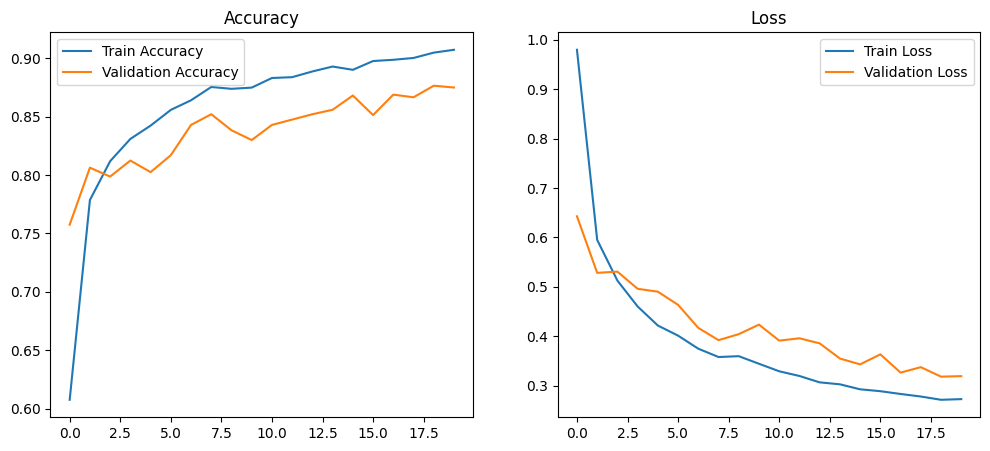

In [17]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss")

plt.show()


41/41 ━━━━━━━━━━━━━━━━━━━━ 30s 459ms/step


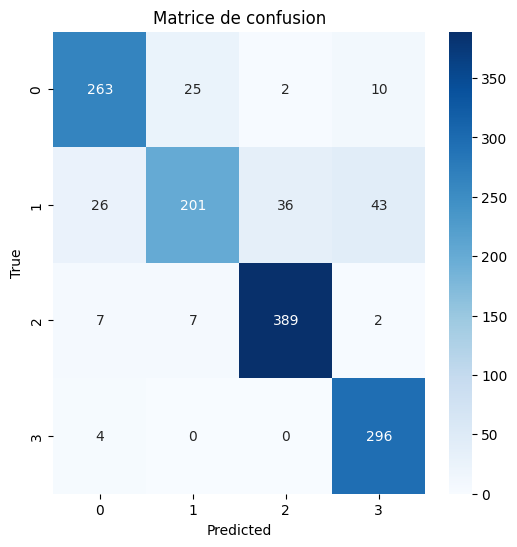

              precision    recall  f1-score   support

      glioma       0.88      0.88      0.88       300
  meningioma       0.86      0.66      0.75       306
     notumor       0.91      0.96      0.94       405
   pituitary       0.84      0.99      0.91       300

    accuracy                           0.88      1311
   macro avg       0.87      0.87      0.87      1311
weighted avg       0.88      0.88      0.87      1311



In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


In [19]:
model.save("DenseNet_Brain_Tumor.h5")


In [20]:
class_names = list(train_generator.class_indices.keys())
print(class_names)


['glioma', 'meningioma', 'notumor', 'pituitary']


In [21]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def predict_image(img_path, model, class_names):
    img = image.load_img(img_path, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction)

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {predicted_class} ({confidence*100:.2f}%)")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


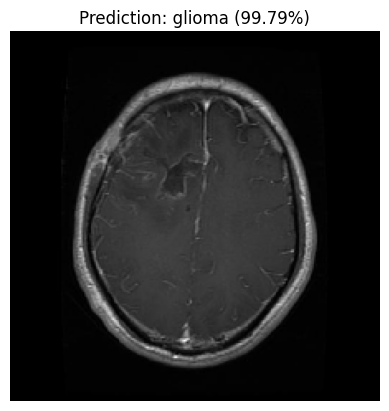

In [22]:
img_path = "/content/drive/MyDrive/Testing/glioma/Te-gl_0016.jpg"
predict_image(img_path, model, class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


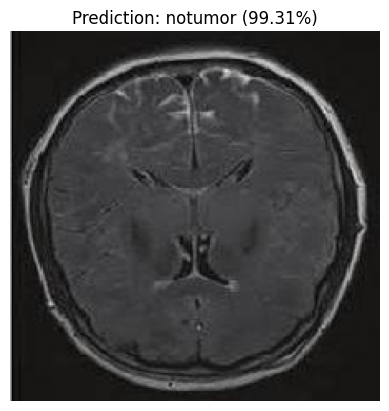

In [23]:
import os, random

test_class = random.choice(class_names)
test_dir = f"/content/drive/MyDrive/Testing/{test_class}"

img_name = random.choice(os.listdir(test_dir))
img_path = os.path.join(test_dir, img_name)

predict_image(img_path, model, class_names)


In [24]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy*100:.2f}%")


41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.8408 - loss: 0.3871
Test Accuracy: 87.64%


In [25]:
from sklearn.metrics import classification_report

y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step
              precision    recall  f1-score   support

      glioma       0.88      0.88      0.88       300
  meningioma       0.86      0.66      0.75       306
     notumor       0.91      0.96      0.94       405
   pituitary       0.84      0.99      0.91       300

    accuracy                           0.88      1311
   macro avg       0.87      0.87      0.87      1311
weighted avg       0.88      0.88      0.87      1311



Les données sont organisées en dossiers Training et Testing avec une classe par sous-dossier. Les prédictions sont interprétées à partir de l’ordre des classes généré automatiquement par Keras afin d’assurer une correspondance correcte entre les sorties du modèle et les labels.

In [26]:
import os
os.getcwd()


'/content'

In [27]:
os.listdir()


['.config', 'DenseNet_Brain_Tumor.h5', 'drive', 'sample_data']

In [28]:
import numpy as np

# Probabilités prédites
y_pred_proba = model.predict(test_generator)

# Classes prédites
y_pred = np.argmax(y_pred_proba, axis=1)

# Vraies classes
y_true = test_generator.classes


41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 317ms/step


In [29]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

accuracy = accuracy_score(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)

print("Accuracy :", accuracy)
print("Balanced Accuracy :", balanced_acc)


Accuracy : 0.8764302059496567
Balanced Accuracy : 0.8701724763979667


In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_micro = precision_score(y_true, y_pred, average='micro')
precision_macro = precision_score(y_true, y_pred, average='macro')

recall_micro = recall_score(y_true, y_pred, average='micro')
recall_macro = recall_score(y_true, y_pred, average='macro')

f1_micro = f1_score(y_true, y_pred, average='micro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print("Precision Micro :", precision_micro)
print("Precision Macro :", precision_macro)
print("Recall Micro :", recall_micro)
print("Recall Macro :", recall_macro)
print("F1 Micro :", f1_micro)
print("F1 Macro :", f1_macro)


Precision Micro : 0.8764302059496567
Precision Macro : 0.8734098699846606
Recall Micro : 0.8764302059496567
Recall Macro : 0.8701724763979667
F1 Micro : 0.8764302059496567
F1 Macro : 0.8667396557935152


In [31]:
from sklearn.metrics import roc_auc_score

mean_auc_macro = roc_auc_score(
    y_true,
    y_pred_proba,
    multi_class='ovr',
    average='macro'
)

mean_auc_micro = roc_auc_score(
    y_true,
    y_pred_proba,
    multi_class='ovr',
    average='micro'
)

print("Mean AUC Macro :", mean_auc_macro)
print("Mean AUC Micro :", mean_auc_micro)


Mean AUC Macro : 0.982108650705338
Mean AUC Micro : 0.9821762810834336


In [32]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_true,
        y_pred,
        target_names=test_generator.class_indices.keys()
    )
)


              precision    recall  f1-score   support

      glioma       0.88      0.88      0.88       300
  meningioma       0.86      0.66      0.75       306
     notumor       0.91      0.96      0.94       405
   pituitary       0.84      0.99      0.91       300

    accuracy                           0.88      1311
   macro avg       0.87      0.87      0.87      1311
weighted avg       0.88      0.88      0.87      1311



In [33]:
results = {
    "Accuracy": accuracy,
    "Balanced Accuracy": balanced_acc,
    "Precision Micro": precision_micro,
    "Precision Macro": precision_macro,
    "Recall Micro": recall_micro,
    "Recall Macro": recall_macro,
    "F1 Micro": f1_micro,
    "F1 Macro": f1_macro,
    "Mean AUC Micro": mean_auc_micro,
    "Mean AUC Macro": mean_auc_macro
}

for metric, value in results.items():
    print(f"{metric}: {value:.4f}")


Accuracy: 0.8764
Balanced Accuracy: 0.8702
Precision Micro: 0.8764
Precision Macro: 0.8734
Recall Micro: 0.8764
Recall Macro: 0.8702
F1 Micro: 0.8764
F1 Macro: 0.8667
Mean AUC Micro: 0.9822
Mean AUC Macro: 0.9821
